# Dimensionality Reduction in Python

In this lecture we will talk about two techniques that can be used to reduce the dimension of your data set: PCA and t-SNE.

## Why Dimensionality Reduction?

In a number of situations we would be fine without reducing the dimension, for instance consider our classic iris dataset.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

iris = sns.load_dataset("iris")

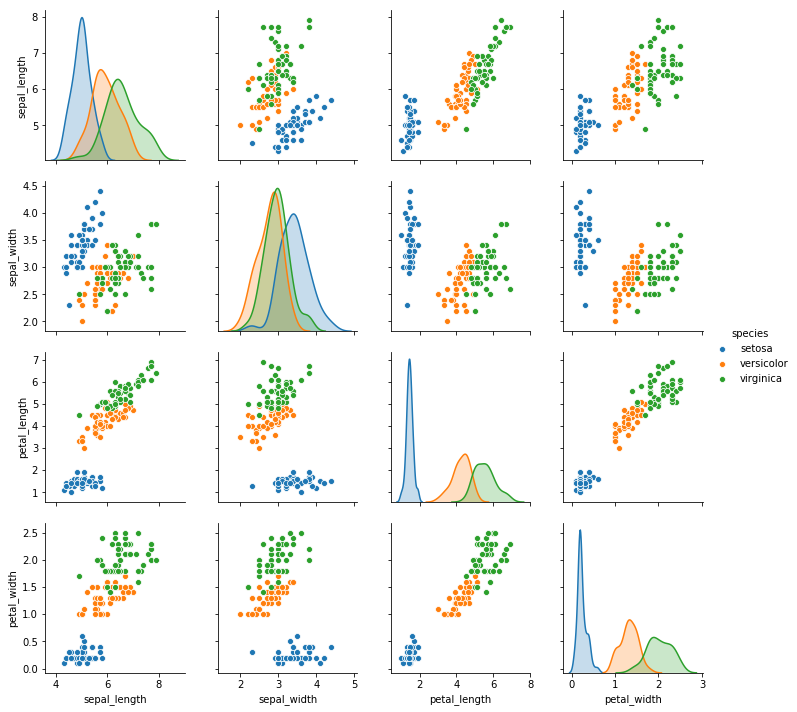

In [2]:
sns.pairplot(iris, hue = "species")
plt.show()

With this data set the dimension is manageable. We are examining 2-dimensional slices of a 4-dimensional data set. We can wrap our 3-dimensional brains around that. However, let's consider the MNSIT dataset.

In [3]:
from sklearn.datasets import load_digits
digits = load_digits()

In [4]:
print(digits.data.shape)

(1797, 64)


<Figure size 432x288 with 0 Axes>

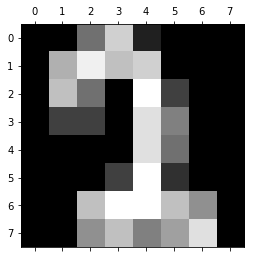

In [5]:
plt.gray()
plt.matshow(digits.images[440])
plt.show()

This data set has many more dimensions, if we wanted to make a pairs plot of this data it would be 64 by 64 and essentially unintelligible. A data reduction could be incredibly useful here.

Dimensionality reduction is useful for both data analysis/visualization and prediction tasks. Let's dive in

## Principal Components Analysis (PCA)

This technique has been around since Karl Pearson's 1903 paper, <a href = "https://www.tandfonline.com/doi/abs/10.1080/14786440109462720"><i>On lines and planes of closest fit to systems of points in space</i></a>. It is well understood and, because of that, very popular. We'll first cover the idea behind PCA, then give a brief outline of its mathematical formulation.

### What is PCA anyway?

This explanation follows the reference: https://www.stat.cmu.edu/~cshalizi/uADA/12/lectures/ch18.pdf.

#### Maximum Information Retention

When you reduce the dimension of a data set you are inherently losing information. Therefore when you reduce the dimension you want to ensure that you do it in a way that "retains as much information as possible". PCA tackles this problem in a very statistical manner.

There's an idea in statistics that the information of a data set is located within that data set's variation. Thus when you reduce the dimension of a data set, you want to project your data onto a hyperplane that captures as much of the original variance in the data as possible. Thinking in terms of optimization, your goal is to project into a lower dimensional hyperplane in a way that maximizes variance.

Here's a heuristic algorithm:
1. Center your data so that each feature has 0 mean.
2. Find the direction in space along which projections have the highest variance, this produces the first principal component.
3. Find the direction orthogonal to the first principal component that maximizes variance, this is the second principal component.
4. Continue in this way, the kth principal component is the variance-maximizing direction orthogonal to the previous k-1 components.

Let's see what we mean in a 2-D example:

In [6]:
import numpy as np

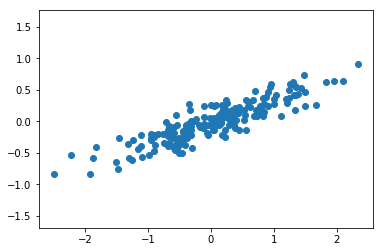

In [7]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(n_components = 2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

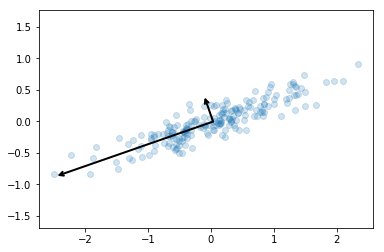

In [10]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Our first principal component is found along the longer arrow, and the second along the shorter arrow.

So how can we go about projecting and maximizing variance in this way?

#### Minimal Perpendicular Lengths

One way to maximize variance is to minimize the collective length of the perpendiculars from the observed data points to the fitted hyperplane. This was actually Pearson's original formulation of the problem, as his goal was to contemplate what we mean by line (or plane) of best fit. Consider this image from Pearson's 1903 paper.

<img src = "PearsonLine.png" width = "500"></img>

Recall that the Mean Square Error is given by the following:
$$
MSE = 1/n\sum_{i = 1}^{n} (\text{observed point }i - \text{fit of point }i )^2
$$
Where we are assuming $n$ total observations and by fit we mean the projection of observation $i$ onto the hyperplane. It can be mathematically shown that minimizing the $MSE$ is equivalent to maximizing the variance!

We will not go through the details here.

#### Eigen Data

Now from the derivation of that fact a constrained optimization problem can be set up, in which the end result shows that the principal components come from the eigenvectors of the covariance matrix of the original data. The first principal component is the eigenvector corresponding to the largest eigenvalue, the second principal component is the eigenvector corresponding to the second largest eigenvalue and so on.

This was just a quick rundown of the mathematics/statistics behind PCA. For more information please read through the two resources I have linked to above. For the rest of the PCA section we will actually implement PCA and see what it can do.

### Implementing PCA

Let's use PCA and see how powerful it can be.

#### The C stands for Cancer

We'll start by showing how PCA can help identify benign and malignant cancer using the `sklearn` cancer data set. Note, this example comes from the book, <u>Introduction to Machine Learning with Python</u>, by Andreas C. M&uuml;ller & Sarah Guido.

In [11]:
# import the data
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

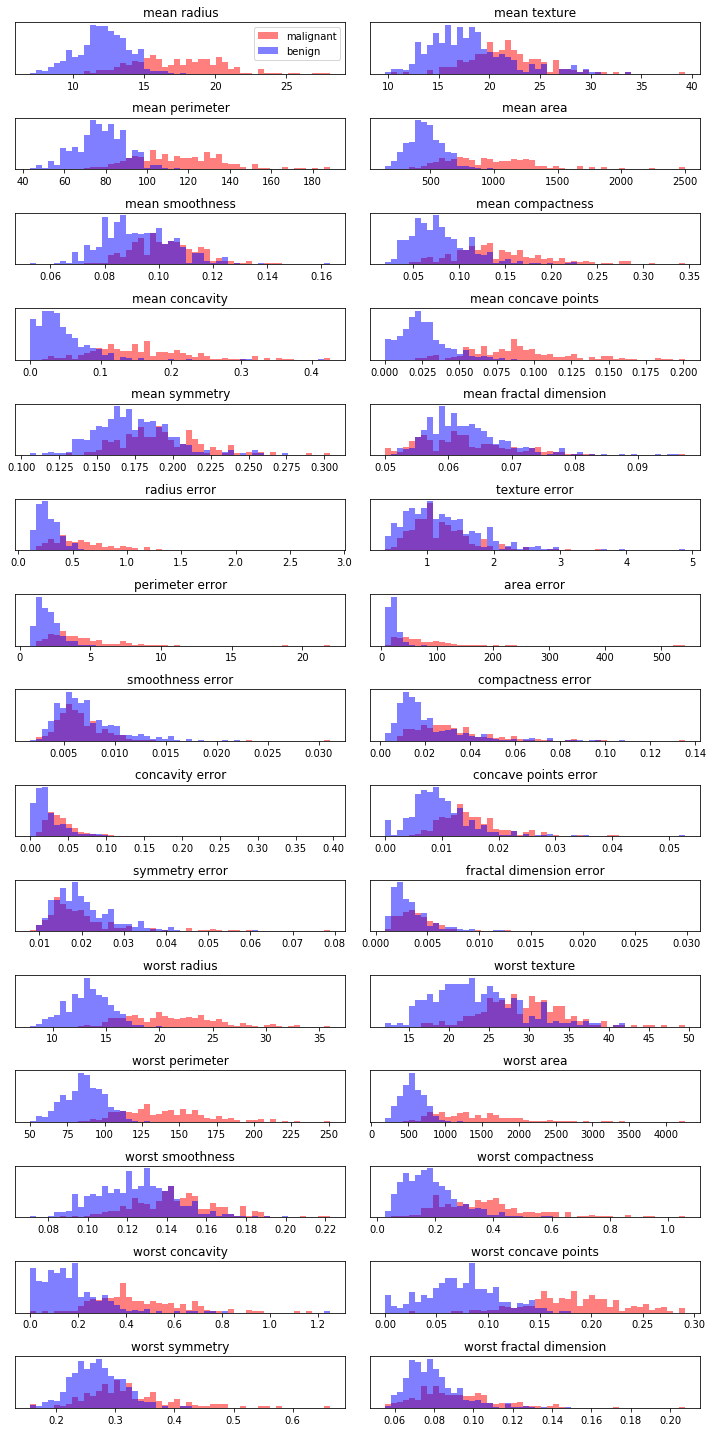

In [12]:
fig, axes = plt.subplots(15, 2, figsize = (10,20))

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins = 50)
    ax[i].hist(malignant[:, i], bins = bins, color = 'red', alpha = .5)
    ax[i].hist(benign[:, i], bins = bins, color = 'blue', alpha = .5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())

ax[0].legend(['malignant', 'benign'], loc = 'best')
    
fig.tight_layout()

As we can see there are definitely some differences between malignant and benign cancer, however, determining cutoffs or decision rules could prove troublesome with 30 different variables to consider. Let's see if PCA with 2 components can help.

Note first we have to preprocess the data a little and scale the variables, otherwise a variable like worst area will have more impact on the variance than a variables like worst symmetry and worst fractal dimension.

In [13]:
from sklearn.preprocessing import StandardScaler

# Scaling the data, standard scaler scales the data 
# like a standard normal rv, this may not be the best way
# to scale the data though
scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

In [14]:
# Now we do PCA
pca = PCA(n_components = 2)

# Fit the PCA model to the scaled data
pca.fit(X_scaled)

# Transform the data
X_pca = pca.transform(X_scaled)

In [15]:
import pandas as pd
import seaborn as sns

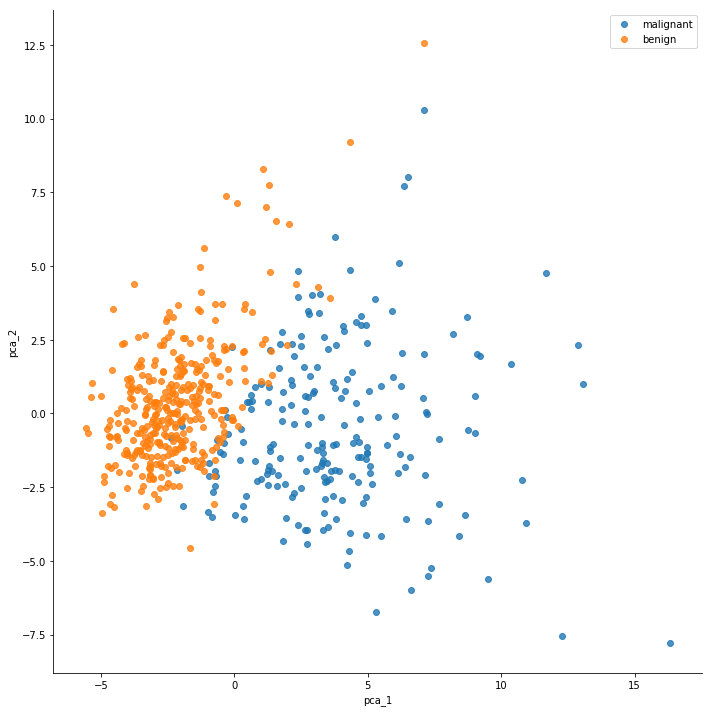

In [16]:
# Now we plot and see what happened:
cancer_pca = pd.DataFrame({'pca_1':X_pca[:,0],'pca_2':X_pca[:,1],'cancer_outcome':cancer.target})

sns.lmplot(data = cancer_pca, x = 'pca_1', y = 'pca_2', hue = 'cancer_outcome', 
           fit_reg = False, legend = False, height = 10, aspect = 1)

plt.legend(cancer.target_names)

plt.show()

As we can see PCA does a pretty good job capturing the split between benign and malignant tumors with only 2 dimensions!

This is wonderful, but if you might have a couple of questions:

1. How can I know how many dimensions are "enough"?
2. Is there anyway to interpret this data in a way that I can relate back to the original problem?

We'll start to answer both of those now.

#### What does it all mean?

A clear downside of PCA is that it isn't very easy to interpret. For instance it isn't clear from our cancer plot above what from the data leads to an increase or decrease in the x and y directions. How can we interpret what separates benign and malignant tumors from this technique?

One way we can attempt to interpret the results is to look at the principal components themselves. Principal components correspond to directions in the original data, so they are combinations of the original features. In some instances we may be able to gleam some insights from the components, however, these can also be quite complex.

In [17]:
pca_comps = pd.DataFrame({'Feature':cancer.feature_names,
                          'First Component':pca.components_[0,:],
                          'Second Component':pca.components_[1,:]})

pca_comps = pca_comps.sort_values(['Second Component'])

pca_comps

,Feature,First Component,Second Component
0,mean radius,0.218902,-0.233857
3,mean area,0.220995,-0.231077
20,worst radius,0.227997,-0.219866
23,worst area,0.224871,-0.219352
2,mean perimeter,0.227537,-0.215181
22,worst perimeter,0.236640,-0.199878
13,area error,0.202870,-0.152293
10,radius error,0.205979,-0.105552
12,perimeter error,0.211326,-0.089457
1,mean texture,0.103725,-0.059706


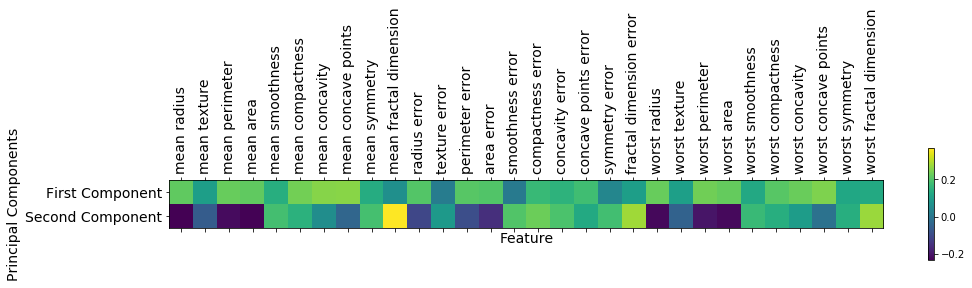

In [18]:
# We can visualize with a heatmap
plt.matshow(pca.components_, cmap = 'viridis')

plt.yticks([0,1], ["First Component", "Second Component"],
          fontsize = 14)

plt.colorbar()

plt.xticks(range(len(cancer.feature_names)),
          cancer.feature_names, rotation = 90, 
          fontsize = 14)

plt.xlabel("Feature", fontsize = 14)
plt.ylabel("Principal Components", fontsize = 14)

plt.show()

Now let's try and interpret the results. Recall that the first component gives us the x-coordinate on our projection plot above. The first component from the PCA is positive for all features. This means that an increase in any one of the features causes an increase in the first component. As we can see from our plot this means that a large value for any one of the features is likely not a good sign, because the right half of the project plot is dominated by malignant observations.

In the second component we have some differences in signs. This can help us identify which features lead to an increase or decrease in our y-coordinate. For instance an increase in mean radius pushes our projection point down in the plot while an increase in mean fractal dimension would push our point up in the plot.

Combining our knowledge of the components with the projection plot can allow us to better understand what features of the data coincide with a malignant observation and what features coincide with a benign observation.

#### Explained Variance Ratio - How many dimensions?

How many dimensions do I need to project down to? Well that depends upon the problem at hand, but `sklearn`'s PCA function does give us the tools to figure out how much of the variance each principal component explains. This is known as the explained variance ratio of the component and is available via the explained_variance_ratio_ variable. These values indicate the proportion of the dataset's variance that lies along the axis of each principal component.

In [19]:
print(pca.explained_variance_ratio_)

[0.44272026 0.18971182]


This outcome tells us that 44.27% of the variance in the original data is contained in the first component and 18.97% in the second component. Perhaps we'd like more variance, or less. We can see how much of the variance we capture in total by taking the cumulative sum of the ratios for each component.

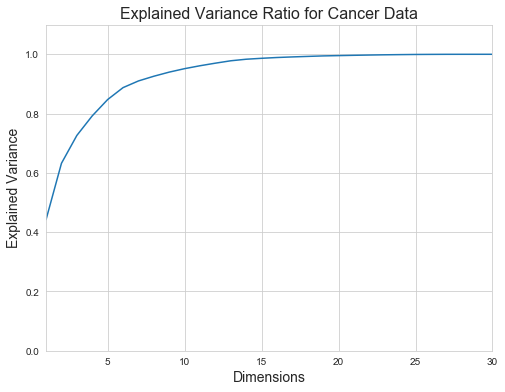

In [20]:
pca = PCA(n_components = 30)

pca.fit(X_scaled)

sns.set_style('whitegrid')

plt.figure(figsize = (8,6))
plt.plot(range(1,31), np.cumsum(pca.explained_variance_ratio_))
plt.axis((1,30,0,1.1))
plt.title("Explained Variance Ratio for Cancer Data",fontsize = 16)
plt.xlabel("Dimensions",fontsize = 14)
plt.ylabel("Explained Variance", fontsize = 14)
plt.show()

A nice feature of `sklearn`'s PCA is that you can tell it what you want the cumulative explained variance ratio to be, and then it will choose the minimum number of components that meat that specification.

In [21]:
# Here's an example where we set it at .85
pca = PCA(n_components = .85)

X_pca = pca.fit_transform(X_scaled)

print(X_pca.shape)

(569, 6)


One rule of thumb for choosing the dimension of the hyperplane is to look for the "elbow" in the cumulative explained variance plot. This is where the explained variance ratio stops growing as quickly and is thought of as the "intrinsic dimensionality of the dataset. This looks to be at around 6 or 7 dimensions for the cancer data set.

We now have a feel for PCA. Before we move on we'll do a few more interesting examples of applying PCA.

### P(olitical) Components Analysis

Political affiliations result in a very natural classification problem. There are clearly marked political affiliations, Republican, Democrat, Independent. As it turns out we can use PCA to help take rather large datasets and project down onto two dimensions that capture political affiliation quite well.

#### Roll Call Classifications

This section was inspired from a talk given by <a href = "https://www.math.ucla.edu/~mason/">Mason Porter</a>, for reference see the two papers he has published <a href = "https://www.sciencedirect.com/science/article/pii/S0378437107007844">here</a> and <a href = "https://www.pnas.org/content/102/20/7057.short">here</a>. 

Every Congress, congressman must meet and cast votes on various bills. Congressman can vote 'Yea', 'Nay', 'Abstain' or be absent. From this information you can construct a matrix for every single session of congress where each row is a congressman and each column is a particular roll call vote. Every entry in this matrix is a $1$ if the congressman voted 'Yea', a $-1$ if the congressman voted 'Nay', and $0$ otherwise.

Below we will see what happens when we put such a matrix through PCA with 2 components.

All data was taken from <a href = "https://voteview.com/data">voteview.com</a>, and then cleaned to be in the presented format.

In [98]:
# We'll look at the 112th Senate
congress_112 = pd.read_csv("Senate_112_roll_mat.csv")

congress_112.loc[congress_112.party_code == 200, "party_code"] = "Republican"
congress_112.loc[congress_112.party_code == 100, "party_code"] = "Democrat"
congress_112.loc[congress_112.party_code == 328, "party_code"] = "Independent"

congress_112.head()

,name,icpsr,party_code,1,2,3,4,5,6,7,...,477,478,479,480,481,482,483,484,485,486
0,"COCHRAN, William Thad",14009,Republican,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
1,"BAUCUS, Max Sieben",14203,Democrat,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,...,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,1.0
2,"GRASSLEY, Charles Ernest",14226,Republican,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,...,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,-1.0
3,"HARKIN, Thomas Richard (Tom)",14230,Democrat,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0
4,"LEAHY, Patrick Joseph",14307,Democrat,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,1.0,1.0


Now the first three columns of the dataframe are identifiers so we know who cast the vote. The name is the name, the icpsr is the identifier code for that congressman in that particular congress, and the party_code is a code given for the political affiliation of the congressman (100 is Democrat, 200 is Republican, and 328 is Independent). The remaining columns each represent a bill that was voted on.

In [129]:
# Retrieve Just the Votes
X = congress_112[list(map(str,range(1,total_votes + 1)))]

# Perform PCA
pca = PCA(n_components = 2)

fit = pca.fit_transform(X)

congress_112_pca = congress_112[['name','icpsr','party_code']].copy()
congress_112_pca['pca_x'] = fit[:,0]
congress_112_pca['pca_y'] = fit[:,1]]

SyntaxError: invalid syntax (<ipython-input-129-3760f7adca7b>, line 11)

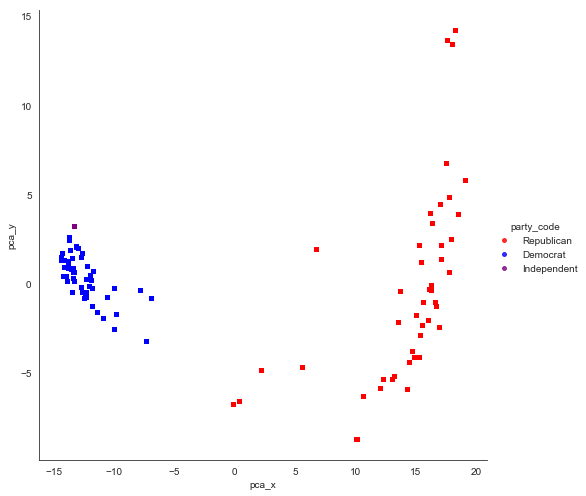

In [130]:
sns.set_style("white")

sns.lmplot(data = congress_112_pca, 
           x = 'pca_x', 
           y = 'pca_y', 
           hue = 'party_code', 
           palette = {"Democrat":'blue', "Republican":'red', "Independent": 'purple'},
           fit_reg = False, 
           height = 7, aspect = 1, 
           scatter_kws = {'s':15})

plt.show()

Now this might not seem too impressive, way to go we recovered that there are two political parties. But think about what we did. We took information stored in 486 columns, compressed it to two columns and still retained meaningful information.

Heck we could even get away with one dimension it seems. Let's examine what it looks like with just the first principal values.

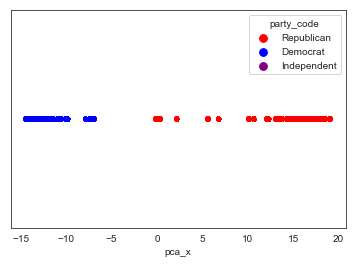

In [126]:
congress_112_pca['Dummy'] = ""

sns.stripplot(data = congress_112_pca, 
              x = 'pca_x',
              y = 'Dummy',
              hue = 'party_code',
              palette = {"Democrat":'blue', "Republican":'red', "Independent": 'purple'}, 
              jitter = 0)

plt.ylabel("")
plt.show()

While the sole independent does get swallowed up here, we see that we only need one dimension to explain the party split. There really isn't much variation in the way our congressman vote. 

A fun fact, the 2-D PCA projection is how voteview.com calculates various ideological scores for Congress members. They then use those scores to make probabilstic predictions on how a congressman will vote on a particular bill. Check out voteview.com for more info!

We could also investigate further. For instance all of the Democrats are much more closer than the Republicans is there a reason for that? There's a cluster of three republicans in the upper right hand corner of the 2-D plot, is there a reason they're further away from the main Republican grouping?

##### Practice

Now you take an opportunity to practice. In the repository are data files for the 113th, 114th, and 115th Senates. Run PCA on those sets and see what you get. Is the output the same as 112th or are there differences over time?

In [68]:
# csvs are stored as Senate_#_roll_mat.csv







#### Twitter Polarization

In [ ]:
test = tsne.fit_transform(X_co)